In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2


In [2]:
import time
import datetime
import os
import sys
import sklearn
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
from matplotlib import pyplot as plt
from data_utils import get_data
from models.resnet import ResNet18
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# enable eager mode to get feature
# 使用 eager mode即动态图模式， tf 1.x 才能得到 中间node输出的feature
tf.compat.v1.enable_eager_execution()

# Data

In [4]:

train_data = loadmat('earthb.mat')
all_data = train_data['images']
all_target = train_data['labels']

# load data
x_train, x_valid, x_test, y_train, y_valid, y_test, splits, splits_test = get_data(all_data, all_target, dataset='eq', seed=1, shape=(-1, 3, 50, 40))
print(x_train.shape, x_valid.shape, x_test.shape)
# set contains training and validation
X = np.concatenate([x_train, x_valid])
y = np.concatenate([y_train, y_valid])



(13883, 3, 50, 40) (1543, 3, 50, 40) (6612, 3, 50, 40)


# ResNet 18

In [5]:
from models.resnet import ResNet18

model = ResNet18([2, 2, 2, 2], n_classes=3)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [6]:
checkpoint_save_path = "./checkpoint/resnet_baseline.ckpt"

start = time.time()
epoch = 30
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

history = model.fit(x_train, y_train, batch_size=32, epochs=epoch, validation_data=(x_valid, y_valid), validation_freq=1,
                    callbacks=[cp_callback])

end = time.time()
print("%d epoch takes %d seconds, " % (epoch, end - start), str(datetime.timedelta(seconds=end-start)))

Train on 13883 samples, validate on 1543 samples
Epoch 1/30
13883/13883 [==============================] - 13s 917us/sample - loss: 0.3243 - sparse_categorical_accuracy: 0.8979 - val_loss: 1.8650 - val_sparse_categorical_accuracy: 0.5625
Epoch 2/30
13883/13883 [==============================] - 7s 496us/sample - loss: 0.1433 - sparse_categorical_accuracy: 0.9602 - val_loss: 0.1557 - val_sparse_categorical_accuracy: 0.9553
Epoch 3/30
13883/13883 [==============================] - 6s 462us/sample - loss: 0.1030 - sparse_categorical_accuracy: 0.9703 - val_loss: 0.1543 - val_sparse_categorical_accuracy: 0.9397
Epoch 4/30
13883/13883 [==============================] - 6s 464us/sample - loss: 0.0875 - sparse_categorical_accuracy: 0.9744 - val_loss: 0.0952 - val_sparse_categorical_accuracy: 0.9708
Epoch 5/30
13883/13883 [==============================] - 6s 448us/sample - loss: 0.0686 - sparse_categorical_accuracy: 0.9801 - val_loss: 0.1888 - val_sparse_categorical_accuracy: 0.9430
Epoch 6/30

In [7]:
result = model.predict(x_test)
pred = tf.argmax(result, axis=1)
pred = pred.numpy()
acc = sklearn.metrics.accuracy_score(y_test, pred)
print('Test accuracy', acc)

Test accuracy 0.956442831215971


# get feature

In [8]:
feature = model(x_test, feature=True).numpy()

In [9]:
feature.shape

(6612, 512)

# Feature Visualization

In [10]:
from sklearn.manifold import TSNE


In [11]:
feature_2d = TSNE(n_components=2, random_state=123).fit_transform(feature)

In [12]:
feature_2d.shape

(6612, 2)

In [13]:
def plotter(feature, pred, y, target_names, acc, title, arg, vis=False, anchors=None):
    """
    function to visualize the outputs of t-SNE
    """
    if feature.shape[1] != 2:
        feature_2d = TSNE(n_components=2, random_state=123).fit_transform(feature)
    else:
        feature_2d = feature

    # choose a color palette with seaborn.
    colors = ['navy', 'turquoise', 'darkorange']
    anchor_colors = ['red', 'purple']
    lw = 2
    # create a scatter plot.
    # if y.sum() != 0:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8))
    plt.suptitle('%s Acc %f' % (title, acc))
    
    # ax = f.add_subplot(211)
    for color, i, target_name in zip(colors, np.arange(len(target_names)), target_names):
        ax1.scatter(feature_2d[y == i, 0], feature_2d[y == i, 1], color=color, alpha=.5, lw=lw, s=2, label=target_name)
    # ax1.axis('off')
    ax1.legend(shadow=False, scatterpoints=1)
    ax1.set_title('Ground Truth')

    for color, i, target_name in zip(colors, np.arange(len(target_names)), target_names):
        ax2.scatter(feature_2d[pred == i, 0], feature_2d[pred == i, 1], color=color, alpha=.5, lw=lw, s=2, label=target_name)
    # else:
    #     for color, i, target_name in zip(colors, np.arange(len(target_names)), target_names):
    #         plt.scatter(feature_2d[pred == i, 0], feature_2d[pred == i, 1], color=color, alpha=.5, lw=lw, s=2, label=target_name)
    #     if anchors is not None:
    #         plt.scatter(feature_2d[anchors[0]][:, 0], feature_2d[anchors[0]][:, 1], color=anchor_colors[0], alpha=.5, lw=lw, s=4, label='SelectA')
    #         plt.scatter(feature_2d[anchors[1]][:, 0], feature_2d[anchors[1]][:, 1], color=anchor_colors[1], alpha=.5, lw=lw, s=4, label='SelectB')
    plt.title('Predicted Label')

    # ax2.axis('off')
    
    # ax.axis('off')
    plt.savefig('tsne_%s.png' % title)
    if vis:
        plt.show(block=False)
    plt.close()

In [14]:
#  y         = [ 0        1      2]
target_names = ['blast', 'eq', 'noise']

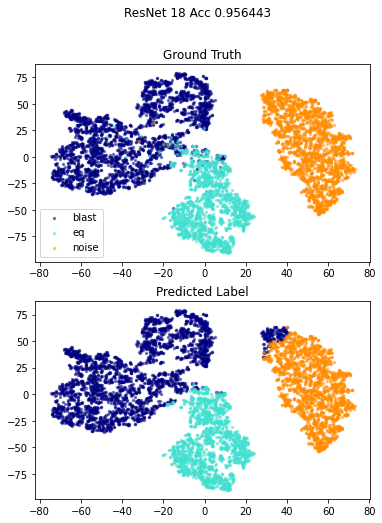

In [15]:
plotter(feature_2d, pred, y_test, target_names, acc, 'ResNet 18', None, vis=True, anchors=None)